In [1]:
import pandas as pd
import scipy.io as sio
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
load_path = '../output/'

In [3]:
df_pvals = pd.DataFrame()
imaging_types = ['rsfMRI', 'MID', 'nBack', 'SST', 'mri_y_dti_fa_fs_wm_dst', 'mri_y_smr_t1_gray_dst']  # sc
for imaging_type in imaging_types:
    for prefix in ['', 'site_corr_', 'covar_regr_', 'balanced_', 'balanced_site_corr_covar_regr_']:  # '', 'covar_regr_', 'site_corr_covar_regr_'
        # load data
        dat = sio.loadmat(os.path.join(load_path, '{:s}levenes_bw_results_{:s}.mat'.format(prefix, imaging_type)))

        # get variance difference
        var_diff = (dat['b_sd'] - dat['w_sd']).ravel()

        # make p value dataframe
        df_tmp = pd.DataFrame({'Imaging Type':len(dat['p_all_bw'])*[imaging_type],
                               'Edge':np.arange(len(dat['p_all_bw'])),
                               'covar':len(dat['p_all_bw'])*[prefix],
                               'Var. Diff. (Black-White)':var_diff,
                              'P':dat['p_all_bw'].ravel(),
                               '0.05':len(dat['p_all_bw'])*[0.05],
                               'pID':len(dat['p_all_bw'])*[dat['pID'][0][0]],
                               'pN':len(dat['p_all_bw'])*[dat['pN'][0][0]],
                              '-log10(P)':-1*np.log10(dat['p_all_bw'].ravel())})
        df_pvals = pd.concat([df_pvals, df_tmp]).reset_index(drop=True)

# replace imaging type
df_pvals['Imaging Type'] = df_pvals['Imaging Type'].apply(lambda x: x.replace('mri_y_dti_fa_fs_wm_dst',
                                                                            'FA').replace('mri_y_smr_t1_gray_dst',
                                                                                          'T1 GM'))
df_pvals.head()

,Imaging Type,Edge,covar,Var. Diff. (Black-White),P,0.05,pID,pN,-log10(P)
0,rsfMRI,0,,0.011141,0.231869,0.05,0.001221,0.000013,0.634758
1,rsfMRI,1,,0.007251,0.627342,0.05,0.001221,0.000013,0.202495
2,rsfMRI,2,,0.002745,0.870065,0.05,0.001221,0.000013,0.060448
3,rsfMRI,3,,0.019881,0.226889,0.05,0.001221,0.000013,0.644186
4,rsfMRI,4,,-0.001342,0.980576,0.05,0.001221,0.000013,0.008519


# Histograms of differences in variance for each imaging feature

In [13]:
df_pvals.covar.unique()

array(['', 'site_corr_', 'covar_regr_', 'balanced_',
       'balanced_site_corr_covar_regr_'], dtype=object)

Text(0.54, 1.02, 'Difference in Variance of Imaging Features between Black and White Participants: p<0.05(balanced, with covariate regr and site corr)')

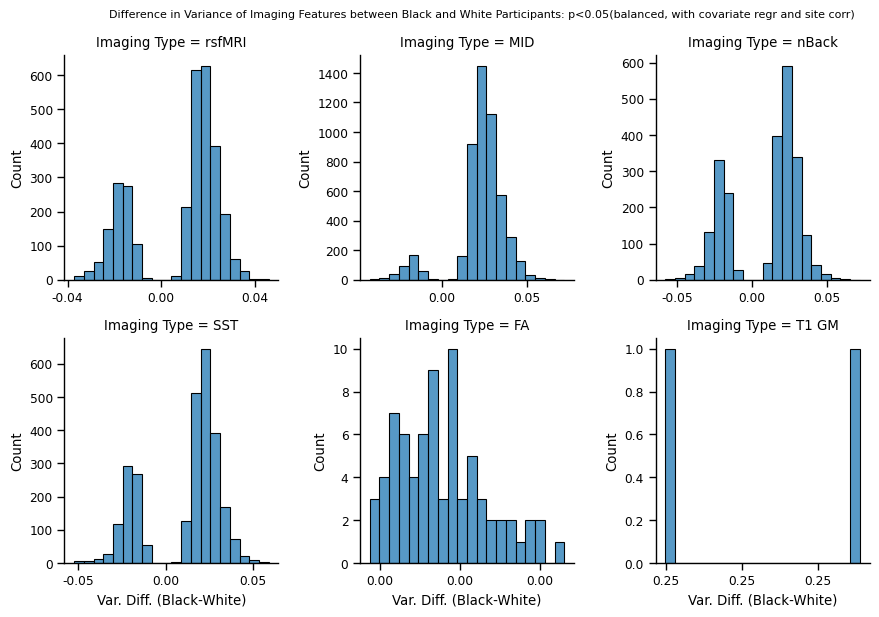

In [21]:
# Set prefix for whether covariate regression and/or site correction
prefix = 'balanced_site_corr_covar_regr_'  # '', 'covar_regr_', 'site_corr_covar_regr_', 'balanced_'. balanced_site_corr_covar_regr_
if prefix=='':
    prefix_title_str = ''
elif prefix=='balanced_':
    prefix_title_str = ' (balanced by race)'
elif prefix=='covar_regr_':
    prefix_title_str = ' (with covariate regr)'
elif prefix=='site_corr':
    prefix_title_str = ' (with site correction)'
elif prefix=='site_corr_covar_regr_':
    prefix_title_str = ' (with covariate regr and site corr)'
elif prefix=='balanced_site_corr_covar_regr_':
    prefix_title_str = '(balanced, with covariate regr and site corr)'

# Set string for significance threshold
sig_thresh_str = '0.05'  # '0.05', 'pID', 'pN'
if sig_thresh_str=='0.05':
    sig_thresh = .05  
elif sig_thresh_str=='pN':
    sig_thresh = dat['pN'][0][0]
elif sig_thresh_str=='pID':
    sig_thresh = dat['pID'][0][0]
    
# restrict dataframe by significance and P threshold
df_plot = df_pvals[(df_pvals.covar==prefix) & 
                   (df_pvals.P<df_pvals[sig_thresh_str])].reset_index(drop=True)
    
sns.set_context('paper')
g = sns.FacetGrid(df_plot, 
                  col="Imaging Type", col_wrap=3, col_order=df_pvals['Imaging Type'].unique(),
                  sharey=False, sharex=False)
g.map(sns.histplot, 'Var. Diff. (Black-White)', bins=20)

# Set x-ticks with 2 decimal places
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

title_str = 'Difference in Variance of Imaging Features between Black and White Participants: p<{:s}{:s}'.format(sig_thresh_str,prefix_title_str)
g.fig.suptitle(title_str,
               fontsize=8, x=0.54, y=1.02)

# Manhattan plot for Levene's p values for each imaging feature

Text(0.54, 1.02, 'Significance of Variance Differences between Black and White Participants(balanced, with covariate regr and site corr)')

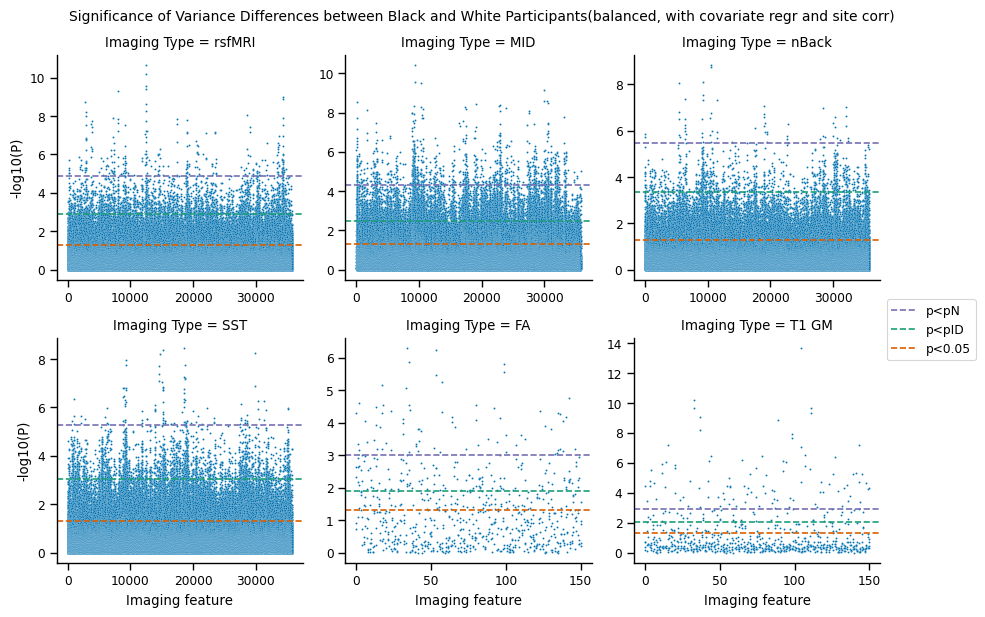

In [11]:
df_pvals = df_pvals.rename(columns={'Edge': 'Imaging feature'})
g = sns.FacetGrid(df_pvals, col="Imaging Type",  col_wrap=3, sharey=False, sharex=False)
g.map(sns.scatterplot, 'Imaging feature', '-log10(P)', s=2, color=sns.color_palette('colorblind')[0])
for ax in g.axes.flatten():
    
    # get title to get FDR p thresholds
    tmp_title = ax.get_title().replace('Imaging Type = ', '')    
    pID = df_pvals[df_pvals['Imaging Type']==tmp_title].pID.unique()[0]
    pN = df_pvals[df_pvals['Imaging Type']==tmp_title].pN.unique()[0]
    
    ax.axhline(-np.log10(pN), color='#7570b3', linestyle='--', label='p<pN')
    ax.axhline(-np.log10(pID), color='#1b9e77', linestyle='--', label='p<pID')
    ax.axhline(-np.log10(.05), color='#d95f02', linestyle='--', label='p<0.05')


plt.legend(bbox_to_anchor=(1, 1.2))
title_str = 'Significance of Variance Differences between Black and White Participants{:s}'.format(prefix_title_str)
g.fig.suptitle(title_str, fontsize=10, x=0.54, y=1.02)

# Tabulate results for variance difference

In [12]:
df_counts = pd.DataFrame()
# Loop over covariate cases and significance cases
for prefix in ['', 'site_corr_', 'covar_regr_', 'balanced_', 'balanced_site_corr_covar_regr_']:  # '', 'balanced_', covar_regr_', 'site_corr_covar_regr_'
    for sig_thresh_str in ['0.05', 'pID', 'pN']:
        
        # restrict dataframe by significance and P threshold
        df_plot = df_pvals[(df_pvals.covar==prefix) & 
                           (df_pvals.P<df_pvals[sig_thresh_str])].reset_index(drop=True)
        df_plot['p_thresh'] = sig_thresh_str
        
        # add in binary columns for sign of variance difference
        df_plot['delta_var_positive'] = 1*(df_plot['Var. Diff. (Black-White)']>0)
        df_plot['delta_var_negative'] = 1*(df_plot['Var. Diff. (Black-White)']<0)
        
        # group by and count number of imaging features with positive/negative variance difference
        df_grouped = df_plot.groupby(['Imaging Type', 'covar', 'p_thresh'],
                                     as_index=False).agg({'delta_var_positive':'sum',
                                                                     'delta_var_negative':'sum'})
        
        # add in zeros for imaging types with no significance
        missing_imaging_types = [I for I in df_pvals['Imaging Type'].unique() if I not in df_plot['Imaging Type'].unique()]
        for m in missing_imaging_types:
            df_grouped = pd.concat([df_grouped,
                                  pd.DataFrame({'Imaging Type':[m],
                                               'covar':[prefix],
                                               'p_thresh':[sig_thresh_str],
                                               'delta_var_positive':[0],
                                               'delta_var_negative':[0]})]).reset_index(drop=True)
        
        df_counts = pd.concat([df_counts, df_grouped]).reset_index(drop=True)

# save file
df_counts = df_counts.rename(columns={'delta_var_positive':'positive_var_diff',
                                     'delta_var_negative':'negative_var_diff'})
df_counts.to_csv('../output/heteroscedasticity_imaging_feature_counts.csv', index=False)
df_counts

,Imaging Type,covar,p_thresh,positive_var_diff,negative_var_diff
0,FA,,0.05,15,55
1,MID,,0.05,7438,674
2,SST,,0.05,4911,896
3,T1 GM,,0.05,25,24
4,nBack,,0.05,3076,1375
...,...,...,...,...,...
85,rsfMRI,balanced_site_corr_covar_regr_,pN,0,0
86,MID,balanced_site_corr_covar_regr_,pN,0,0
87,nBack,balanced_site_corr_covar_regr_,pN,0,0
88,SST,balanced_site_corr_covar_regr_,pN,0,0
